# 0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pyspark as sp
import findspark

from pyspark.sql import SparkSession

# 1. Find Spark

Adding pyspark to sys.path at runtime using the library findspark

In [2]:
findspark.init()
findspark.find()

'C:\\spark-3.4.1-bin-hadoop3'

# 2. Creating SparkSession

One aspect of the explanation why SparkSession is preferable over SparkContext in SparkSession Vs SparkContext battle is that SparkSession unifies all of Spark’s numerous contexts, removing the developer’s need to worry about generating separate contexts.

In [3]:
#Create the SparkSession
my_spark = SparkSession.builder.getOrCreate()

#print the session
print(my_spark)

# 3. Dataset overview

In [4]:
df = my_spark.read.csv('2017_StPaul_MN_Real_Estate.csv', header=True)
df.columns

['No.',
 'MLSID',
 'StreetNumberNumeric',
 'streetaddress',
 'STREETNAME',
 'PostalCode',
 'StateOrProvince',
 'City',
 'SalesClosePrice',
 'LISTDATE',
 'LISTPRICE',
 'LISTTYPE',
 'OriginalListPrice',
 'PricePerTSFT',
 'FOUNDATIONSIZE',
 'FENCE',
 'MapLetter',
 'LotSizeDimensions',
 'SchoolDistrictNumber',
 'DAYSONMARKET',
 'offmarketdate',
 'Fireplaces',
 'RoomArea4',
 'roomtype',
 'ROOF',
 'RoomFloor4',
 'PotentialShortSale',
 'PoolDescription',
 'PDOM',
 'GarageDescription',
 'SQFTABOVEGROUND',
 'Taxes',
 'RoomFloor1',
 'RoomArea1',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LivingArea',
 'UNITNUMBER',
 'YEARBUILT',
 'ZONING',
 'STYLE',
 'ACRES',
 'CoolingDescription',
 'APPLIANCES',
 'backonmarketdate',
 'ROOMFAMILYCHAR',
 'RoomArea3',
 'EXTERIOR',
 'RoomFloor3',
 'RoomFloor2',
 'RoomArea2',
 'DiningRoomDescription',
 'BASEMENT',
 'BathsFull',
 'BathsHalf',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'Class',
 'BATHSTOTAL',
 'BATHDESC',
 'RoomArea5',
 'RoomFloor5',
 'RoomArea6',
 'RoomFloor6'

In [5]:
# Select our dependent variable
Y_df = df.select(['SalesClosePrice'])

# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|            100000|
|    max|             99900|
+-------+------------------+



# 4. Preprocessing data I

In [6]:
#Check data of the feature to predict 
df.select(["SalesClosePrice"]).dtypes

[('SalesClosePrice', 'string')]

In [7]:
# convert the data type of SalesClosePrice to integer
df = df.withColumn("SalesClosePrice", df.SalesClosePrice.cast("integer"))

In [8]:
#Check again the type after converting it.
df.select(["SalesClosePrice"]).dtypes

[('SalesClosePrice', 'int')]

In [9]:
df.select('SalesClosePrice').describe().show()

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



In [10]:
#Modifying some types of key variables
df = df.withColumn("AssessedValuation", df.AssessedValuation.cast("double"))
df = df.withColumn("AssociationFee", df.AssociationFee.cast("bigint"))
df = df.withColumn("SQFTBELOWGROUND", df.SQFTBELOWGROUND.cast("bigint"))

In [11]:
#modifying name of column to capital letters
required_dtypes = [('NO', 'bigint'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'bigint'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'bigint'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'bigint'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'bigint'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'bigint'),
 ('PRICEPERTSFT', 'double'),
 ('FOUNDATIONSIZE', 'bigint'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'bigint'),
 ('OFFMARKETDATE', 'string'),
 ('FIREPLACES', 'bigint'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'bigint'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'bigint'),
 ('TAXES', 'bigint'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'bigint'),
 ('LIVINGAREA', 'bigint'),
 ('UNITNUMBER', 'string'),
 ('YEARBUILT', 'bigint'),
 ('ZONING', 'string'),
 ('STYLE', 'string'),
 ('ACRES', 'double'),
 ('COOLINGDESCRIPTION', 'string'),
 ('APPLIANCES', 'string'),
 ('BACKONMARKETDATE', 'double'),
 ('ROOMFAMILYCHAR', 'string'),
 ('ROOMAREA3', 'string'),
 ('EXTERIOR', 'string'),
 ('ROOMFLOOR3', 'string'),
 ('ROOMFLOOR2', 'string'),
 ('ROOMAREA2', 'string'),
 ('DININGROOMDESCRIPTION', 'string'),
 ('BASEMENT', 'string'),
 ('BATHSFULL', 'bigint'),
 ('BATHSHALF', 'bigint'),
 ('BATHQUARTER', 'bigint'),
 ('BATHSTHREEQUARTER', 'double'),
 ('CLASS', 'string'),
 ('BATHSTOTAL', 'bigint'),
 ('BATHDESC', 'string'),
 ('ROOMAREA5', 'string'),
 ('ROOMFLOOR5', 'string'),
 ('ROOMAREA6', 'string'),
 ('ROOMFLOOR6', 'string'),
 ('ROOMAREA7', 'string'),
 ('ROOMFLOOR7', 'string'),
 ('ROOMAREA8', 'string'),
 ('ROOMFLOOR8', 'string'),
 ('BEDROOMS', 'bigint'),
 ('SQFTBELOWGROUND', 'bigint'),
 ('ASSUMABLEMORTGAGE', 'string'),
 ('ASSOCIATIONFEE', 'bigint'),
 ('ASSESSMENTPENDING', 'string'),
 ('ASSESSEDVALUATION', 'double')]

In [12]:
old_columns = df.columns

In [13]:
new_columns = [c for c, d in required_dtypes]

In [14]:
for n, o in zip(new_columns, old_columns): 
    df = df.withColumnRenamed(o, n)

In [15]:
#Checking the transformation of column names to capital letters
df.dtypes

[('NO', 'string'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'string'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'string'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'int'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'string'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'string'),
 ('PRICEPERTSFT', 'string'),
 ('FOUNDATIONSIZE', 'string'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'string'),
 ('OFFMARKETDATE', 'string'),
 ('FIREPLACES', 'string'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'string'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'string'),
 ('TAXES', 'string'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'string'),
 ('TAXYEAR', 'strin

In [16]:
for required_type, current_column in zip(required_dtypes, df.columns):
    # since the required and current column names are the exact order we can do:
    if required_type[1] != 'string':
        df = df.withColumn(current_column, df["{:}".format(current_column)].cast(required_type[1]))

In [17]:
df.dtypes

[('NO', 'bigint'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'bigint'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'bigint'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'bigint'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'bigint'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'bigint'),
 ('PRICEPERTSFT', 'double'),
 ('FOUNDATIONSIZE', 'bigint'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'bigint'),
 ('OFFMARKETDATE', 'string'),
 ('FIREPLACES', 'bigint'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'bigint'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'bigint'),
 ('TAXES', 'bigint'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'bi

In [18]:
check_columns = ['FOUNDATIONSIZE',
 'DAYSONMARKET',
 'FIREPLACES',
 'PDOM',
 'SQFTABOVEGROUND',
 'TAXES',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LIVINGAREA',
 'YEARBUILT',
 'ACRES',
 'BACKONMARKETDATE',
 'BATHSFULL',
 'BATHSHALF',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'BEDROOMS',
 'SQFTBELOWGROUND',
 'ASSOCIATIONFEE',
 'ASSESSEDVALUATION']

In [19]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = check_columns[0]

# Loop to check all columns contained in list
for col in check_columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(col, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


# 5. Visualizations

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

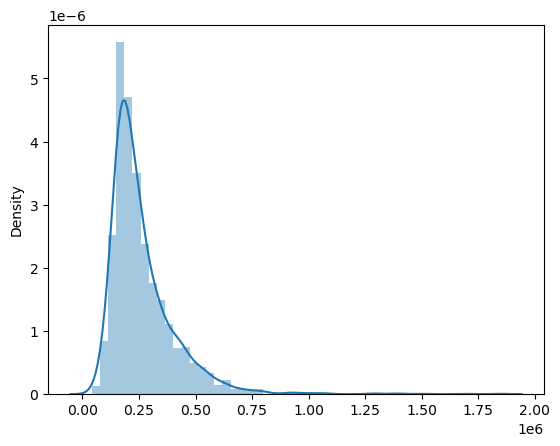

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [21]:
# Select a single column and sample and convert to pandas
# sample 50% and not use replacement and setting the random seed to 42.
sample_df = df.select(['LISTPRICE']).sample(False, .5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

In [22]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE','LIVINGAREA']).sample(False, .5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

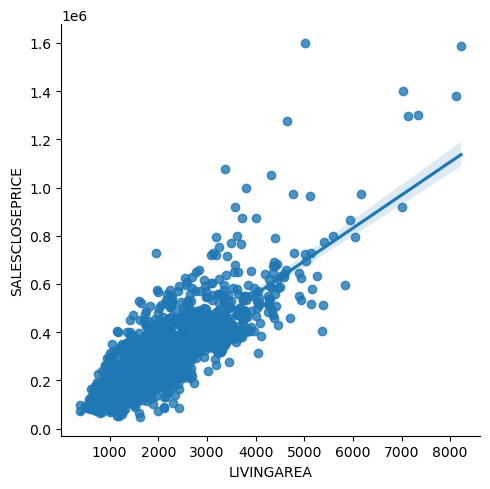

In [23]:
# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)

We can see a relation. If Livingarea increase, the salescloseprice also increases.

# 6. Preprocessing data II

### 6.1 Dropping a list of columns

In [24]:
# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

### 6.2 Using text filters to remove records

In [25]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [26]:
df.groupBy('ASSUMABLEMORTGAGE').count().show()

+-------------------+-----+
|  ASSUMABLEMORTGAGE|count|
+-------------------+-----+
|  Yes w/ Qualifying|   21|
| Information Coming|   29|
|               null| 3104|
|Yes w/No Qualifying|    3|
|      Not Assumable| 1843|
+-------------------+-----+



In [27]:
df.count()

5000

In [28]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

In [29]:
df.count()

4976

In [30]:
# We kept values that were null and values that where not in the list provided.
df.groupBy('ASSUMABLEMORTGAGE').count().show()

+------------------+-----+
| ASSUMABLEMORTGAGE|count|
+------------------+-----+
|Information Coming|   29|
|              null| 3104|
|     Not Assumable| 1843|
+------------------+-----+



### 6.3 Filtering numeric fields conditionally

In [31]:
#Changing column to his log value.
from pyspark.sql.functions import log
df = df.withColumn('log_SalesClosePrice', log('SalesClosePrice'))

In [32]:
# Select a the relevant columns and sample
sample_df = df.select(['log_SalesClosePrice'])

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

In [33]:
pandas_df.head()

,log_SalesClosePrice
0,11.870600
1,12.154779
2,12.323856
3,12.487485
4,12.428816


<AxesSubplot:xlabel='log_SalesClosePrice'>

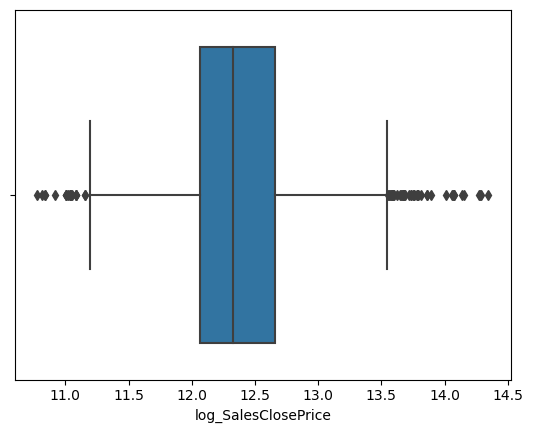

In [34]:
sns.boxplot(x=pandas_df["log_SalesClosePrice"])

In [35]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

In [36]:
# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

In [37]:
df.count()

4976

In [38]:
# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

In [39]:
df.count()

4946

<AxesSubplot:xlabel='log_SalesClosePrice'>

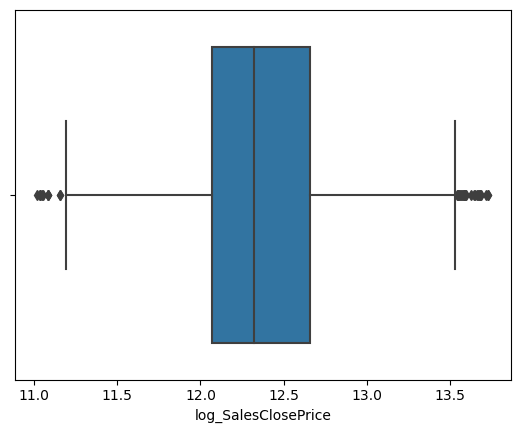

In [40]:
# Check that we have deleted outliers
sample_df = df.select(['log_SalesClosePrice'])
pandas_df = sample_df.toPandas()
sns.boxplot(x=pandas_df["log_SalesClosePrice"])

### 6.4 Custom Percentage Scaling

Creating a manual scaling of the Daysonmarket column

In [41]:
from pyspark.sql.functions import round

In [42]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

In [43]:
# Create a new column based off the scaled data using the formula manually
df = df.withColumn('percentage_scaled_days', 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)


In [44]:
# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


<AxesSubplot:xlabel='DAYSONMARKET'>

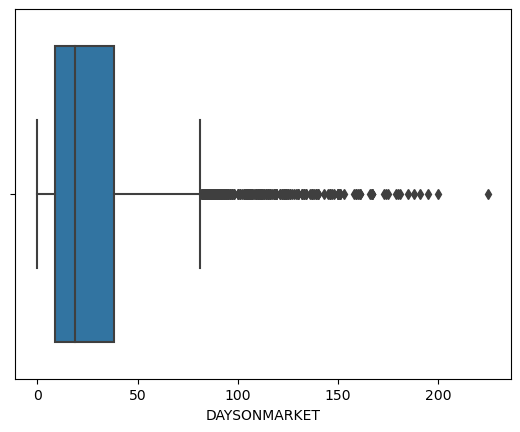

In [45]:
sample_df = df.select(['DAYSONMARKET'])
pandas_df = sample_df.toPandas()
sns.boxplot(x=pandas_df["DAYSONMARKET"])

<AxesSubplot:xlabel='percentage_scaled_days'>

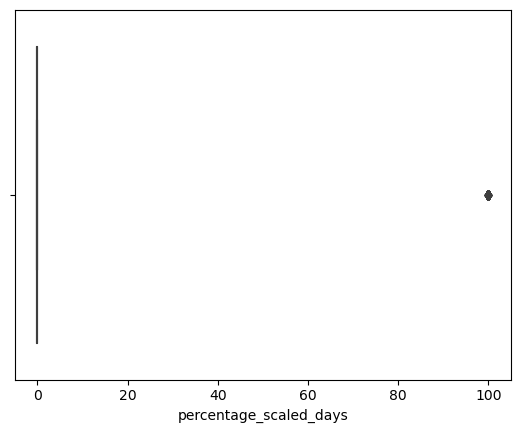

In [46]:
sample_df = df.select(['percentage_scaled_days'])
pandas_df = sample_df.toPandas()
sns.boxplot(x=pandas_df["percentage_scaled_days"])

### 6.5 Scaling your scalers

Creating a function that will scale automatically the desired features.

In [47]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                          (df[col] - min_days) / (max_days - min_days))
    return df

In [48]:
df = min_max_scaler(df, ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES'])

In [49]:
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



### 6.6 Correcting Right Skew Data

In [50]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


### 6.7 Visualizing Missing Data

In [51]:
columns = ['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

In [52]:
df.select(columns).show()

+--------------------+----------------+--------------------+--------------------+---------------------+
|          APPLIANCES|BACKONMARKETDATE|      ROOMFAMILYCHAR|            BASEMENT|DININGROOMDESCRIPTION|
+--------------------+----------------+--------------------+--------------------+---------------------+
|Range, Dishwasher...|            null|                null|                Full|       Eat In Kitchen|
|Range, Microwave,...|            null|         Lower Level|Full, Partial Fin...| Informal Dining R...|
|Range, Microwave,...|            null|                null|Full, Crawl Space...| Informal Dining Room|
|Range, Washer, Dryer|            null|          Main Level|Full, Partial Fin...|                 null|
|Range, Exhaust Fa...|            null|         Lower Level|Walkout, Full, Fi...| Breakfast Area, K...|
|Range, Microwave,...|            null|                null|Full, Sump Pump, ...| Separate/Formal D...|
|Range, Microwave,...|            null|                Loft|    

In [53]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

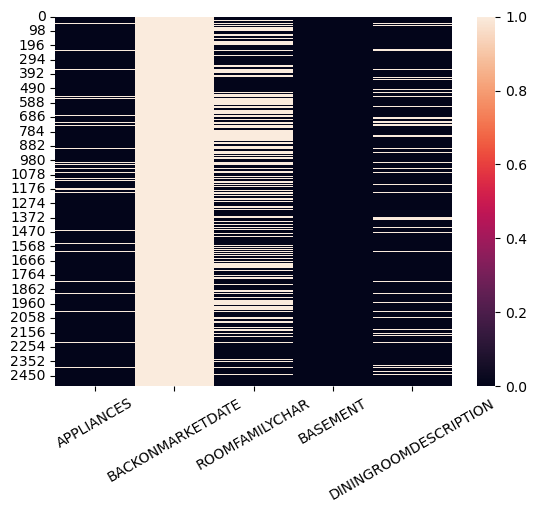

In [54]:
# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

Sources:
https://github.com/ozlerhakan/datacamp/blob/master/Feature%20Engineering%20with%20PySpark/Feature%20Engineering%20with%20PySpark.ipynb